In [1]:
using OrdinaryDiffEq
using Plots, LaTeXStrings
using CSV
using DataFrames
using Dates

In [2]:
figdir = "figures/";

In [3]:
ENV["COLUMNS"]=120
ENV["LINES"]=20;

## Standard virus load function

The standard virus load function with three main phases given by

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function.

In [4]:
heaviside(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.5)))
v₁(t, a₁, a₂, Vmax) = 1. + (Vmax - 1.0)*(tanh(6.0*(t - (a₁ + a₂)/2)/(a₂ - a₁)) - tanh(-3.0*(a₂ + a₁)/(a₂ - a₁)))/2
v₂(t, a₂, α) = 1. - heaviside(t - a₂) + heaviside(t - a₂)*exp(-α*(t - a₂))
v₃(t, b₁, b₂, Vmin) = 1. - (1.0 - Vmin)*(tanh(6.0*(t - (b₁ + b₂)/2)/(b₂ - b₁)) - tanh(-3.0*(b₂ + b₁)/(b₂ - b₁)))/2
function VLF(t, a₁, a₂, b₁, b₂, α, Vmax, Vmin)
    v₁(t, a₁, a₂, Vmax)*v₂(t, a₂, α)*v₃(t, b₁, b₂, Vmin)
end

VLF (generic function with 1 method)

## Kinetic model

The within-host model for COVID-19 infections dynamics on the lung epithilium, $E$, is given by

$$
\begin{aligned}
    \frac{d E}{dt} & = \mu_E E(1-E) - \delta_E T \frac{V}{V_{max}}.
\end{aligned}
$$ 

In [42]:
function model!(du, u, p, t)
    E, = u
    a₁, a₂, b₁, b₂, α, Vmax, Vmin, μ_E, δ_E = p
    # Lung damage
    du[1] = dE = μ_E*E*(1.0 - E) - δ_E*E*VLF(t, a₁, a₂, b₁, b₂, α, Vmax, Vmin)/Vmax # Healthy lung epithelium
end

model! (generic function with 1 method)

Initial conditions and parameter values

In [64]:
# initial
u0 = [
    1.0   # E: Healthy lung epithilium
]
tspan = (0.0, 40.0)
pars = [
    0.5     # a₁
    4.0     # a₂
    13.0    # b₁
    19.0    # b₂
    0.1     # α
    1000.0  # Vmax
    1e-8    # Vmin
    0.01    # μ_E
    0.2     # δ_E
    ]
parnames = [:a₁, :a₂, :b₁, :b₂, :α, :Vmax, :Vmin, :μ_E, :δ_E]
thresholds = (E = 0.3,);

Solve the ODE problem

In [65]:
prob = ODEProblem(model!, u0, tspan, pars)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 40.0)
u0: [1.0]

In [66]:
sol = solve(prob, Tsit5(), dtmax=1e-1);

## Plotting

Plot the solution in a 3 by 3 grid. 

In [67]:
function plot_sol(sol; kwargs...)
    plot(layout=2, legend=:none, grid=:none, size=(600,300))
    plot_sol!(sol; kwargs...) 
end
function plot_sol!(sol; kwargs...)
    tt = range(0.0, tspan[2], length=100)
    pars = sol.prob.p
    vv = VLF.(sol.t, pars[1], pars[2], pars[3], pars[4], pars[5], pars[6], pars[7])
    plot!(sol.t, vv, lw=3, xaxis=("Time (days)"), yaxis=("Viral load", (0, 1300)), subplot=1; kwargs...)
    plot!(sol, vars=1, lw=3, xaxis=("Time (days)"), yaxis=("Healthy lung epithelium", (0, 1.1)), subplot=2; kwargs...) 
    plot!(collect(extrema(sol.t)), [thresholds.E, thresholds.E], color=:black, lw=2, subplot=2)
end

plot_sol! (generic function with 1 method)

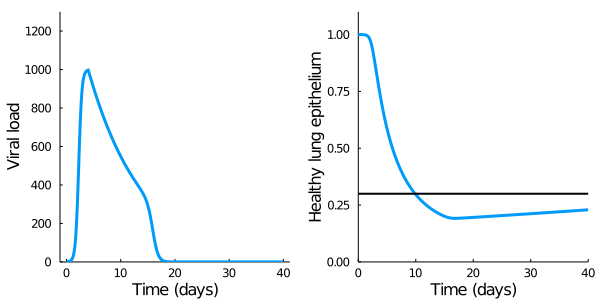

In [68]:
plot_sol(sol)

## Data

In [35]:
df = DataFrame(CSV.File("../../data/AHS Public/covid19syntheticdata.csv"))

,Column1,Date reported,Alberta Health Services Zone,Gender,Age group,Case status,Case type,Hospitalized,ICU
,Int64,Date,String,String,String,String,String,Bool,Bool
1,0,2020-11-13,Calgary Zone,Female,1-4 years,Recovered,Confirmed,0,0
2,1,2021-01-03,Calgary Zone,Female,5-9 years,Recovered,Confirmed,0,0
3,2,2020-12-13,Edmonton Zone,Male,5-9 years,Recovered,Confirmed,0,0
4,3,2021-01-05,Central Zone,Male,50-59 years,Recovered,Confirmed,0,0
5,4,2021-01-30,Calgary Zone,Female,1-4 years,Recovered,Confirmed,0,0
6,5,2021-01-20,Edmonton Zone,Female,Under 1 year,Recovered,Confirmed,0,0
7,6,2020-12-06,Central Zone,Female,10-19 years,Recovered,Confirmed,0,0
8,7,2021-01-14,Calgary Zone,Female,40-49 years,Recovered,Confirmed,0,0
9,8,2020-11-18,Edmonton Zone,Female,10-19 years,Recovered,Confirmed,0,0


In [36]:
df = df[df."Case type" .== "Confirmed", :]
df = df[df."Case status" .!= "Active", :]
df = df[df.Hospitalized .& df.ICU, :]

,Column1,Date reported,Alberta Health Services Zone,Gender,Age group,Case status,Case type,Hospitalized,ICU,Number of comorbidities
,Int64,Date,String,String,String,String,String,Bool,Bool,Int64
1,179,2020-12-13,Calgary Zone,Male,30-39 years,Recovered,Confirmed,1,1,1
2,238,2020-12-31,Calgary Zone,Female,50-59 years,Recovered,Confirmed,1,1,1
3,263,2021-01-22,Edmonton Zone,Female,60-69 years,Recovered,Confirmed,1,1,0
4,314,2020-12-21,Edmonton Zone,Female,50-59 years,Recovered,Confirmed,1,1,2
5,872,2021-01-22,Edmonton Zone,Female,50-59 years,Recovered,Confirmed,1,1,1
6,969,2020-11-20,Calgary Zone,Female,50-59 years,Recovered,Confirmed,1,1,3
7,1319,2020-11-07,Central Zone,Female,60-69 years,Recovered,Confirmed,1,1,3
8,1383,2020-12-31,Edmonton Zone,Male,70-79 years,Recovered,Confirmed,1,1,2
9,1469,2020-12-07,Edmonton Zone,Male,60-69 years,Recovered,Confirmed,1,1,2


In [38]:
df[1:20,18:end]

,Stroke,Liver Diseases,Immuno-Deficiency Diseases,Admission date,Oxygen saturation,D-Dimer,C reactive
,Bool,Bool,Bool,Date?,Float64?,Float64?,Float64?
1,0,0,0,2020-12-14,96.0,274.0,96.9
2,1,0,0,2021-01-02,93.4,412.0,95.2
3,0,0,0,2021-01-25,94.5,484.0,93.6
4,1,0,0,2020-12-21,95.2,309.0,95.7
5,0,0,0,2021-01-24,95.6,390.0,95.7
6,0,0,0,2020-11-22,96.1,382.0,95.3
7,0,0,0,2020-11-10,94.4,553.0,93.4
8,0,0,0,2021-01-04,93.4,594.0,93.9
9,0,0,0,2020-12-13,95.2,384.0,93.2


In [40]:
x = float(Dates.value.(df."Admission date" - df."Date reported"))
y = df."Oxygen saturation"

1068-element Array{Union{Missing, Float64},1}:
 96.0
 93.4
 94.5
 95.2
 95.6
 96.1
 94.4
 93.4
  ⋮
 94.1
 96.1
 97.3
 95.3
 94.3
 88.3
 91.9

## Model

In [ ]:
function model(t, p, data, u0)
    # steady state IC's
    u0 = [1.0]
    # simulate 30 days
    tspan = (0.0, 30.0)
    pars = p
    prob = ODEProblem(model!, u0, tspan, pars)
    sol = solve(prob, Tsit5(), dtmax=1e-1)
    sol(t)[end, :]
end


In [ ]:
model(t, p) = LogEmpiricalViralTargetModel(t, p, data, u0)
    fit = curve_fit(model, data.t, data.v, p0, lower=lb, upper=ub)